# Cel projektu

Celem projektu było sprawdzenie, czy da się przewidywać, które rezerwacje będą
długie (co najmniej 7 nocy), oraz które cechy ofert są z tym związane w sposób
na tyle czytelny, żeby konsultanci mogli dawać właścicielom praktyczne
rekomendacje.

Zadanie modelowe: klasyfikacja binarna.

- `y = 1` – rezerwacja długa ($\geq 7$ nocy)
- `y = 0` – rezerwacja krótka ($<7$ nocy)

# Jakie dane wykorzystaliśmy

Do budowy zbioru treningowego wybraliśmy takie dane, które spełniają dwa
warunki:

1. da się je powiązać z konkretną rezerwacją,
1. wynik modelu można przełożyć na rekomendacje dotyczące oferty (co właściciel
   może zmienić).

W praktyce oznaczało to wykorzystanie głównie:

- informacji o rezerwacji (daty, długość pobytu) do zbudowania targetu,
- cech oferty z `listings.csv`, które opisują standard i warunki pobytu,
- udogodnień (amenities), ponieważ są bezpośrednio „wdrażalne”.

Sprawdziliśmy, że obecnie w kluczowych atrybutach albo nie ma braków danych,
albo są one nieliczne i można je uzupełnić prostymi metodami (np. medianą lub
najczęstszą wartością).

Zauważyliśmy, również, że w porównaniu do poprzedniego zbioru danych, jesteśmy w
stanie złączyć rezerwacje z cechami ofert (`join_coverage` wzrosło do 100%).

## Dane rezerwacji (podstawa do targetu)

Target `long_stay` został zbudowany na podstawie różnicy pomiędzy datą
rozpoczęcia a datą zakończenia pobytu. Dzięki temu target wynika bezpośrednio z
danych rezerwacyjnych, a nie z ręcznych etykiet.

Dodatkowo policzono długość pobytu w nocach i odrzucono ewidentnie błędne
przypadki (np. 0 nocy lub bardzo długie pobyty, które wyglądały na artefakty w
danych).

## Dane ofert (cechy obiektu i hosta)

Z `listings.csv` wybrano cechy, które opisują ofertę w sposób zrozumiały i
potencjalnie istotny dla dłuższego pobytu, np.:

- parametry przestrzeni i pojemności: `accommodates`, `bedrooms`, `beds`,
  `bathrooms`,
- typ oferty: `room_type`,
- ograniczenia rezerwacji: `minimum_nights`, `maximum_nights` oraz pochodne,
- wybrane cechy hosta i sygnały jakości: `host_response_time`,
  `host_is_superhost`, `number_of_reviews`, `review_scores_*`.

Założenie: dłuższy pobyt zwykle wymaga „funkcjonalności mieszkania” (kuchnia,
pralka, przestrzeń, prywatność) oraz stabilnych warunków (jasne zasady pobytu,
przewidywalność hosta).

## Udogodnienia (amenities)

Udogodnienia zostały potraktowane jako ważna część modelu z dwóch powodów:

- są mocno powiązane z komfortem dłuższego pobytu,
- konsultant może je łatwo przełożyć na rekomendację dla właściciela.

Aby w praktyce użyć `amenities` w modelu, zrobiono dwie rzeczy:

- policzono `amenities_count` jako ogólną miarę „bogactwa wyposażenia”,
- wybrano najczęstsze udogodnienia i zakodowano je jako cechy 0/1 (np.
  `amen_kitchen`, `amen_washer`, `amen_wifi`).

# Jakie dane zostały wykluczone i dlaczego

W trakcie pracy celowo wykluczono część potencjalnych cech. Powody były głównie
dwa: wiarygodność czasowa danych oraz praktyczna użyteczność dla rekomendacji.

## Wykluczenie `price`

`price` pochodzi z `listings.csv`, natomiast dane rezerwacji obejmują wiele lat.
`listings.csv` jest snapshotem ofert z jednego okresu, więc cena z tego pliku
nie musi odpowiadać cenie obowiązującej w momencie konkretnej rezerwacji.

To jest nie tylko problem „szumu”, ale może też prowadzić do wycieku czasowego.
Jeżeli snapshot ofert został zebrany później niż część rezerwacji, to `price`
może odzwierciedlać stan rynku i decyzje hostów z przyszłości (np. po wzroście
popytu lub po zmianach strategii), których nie było w momencie rezerwacji. W
takim przypadku model uczy się sygnału dostępnego dopiero po czasie.

Z tego powodu `price` został wykluczony z cech wejściowych, pomimo, że jest
najbardziej skorelowany z przewidywanym targetem. Wykorzystanie samego atrybytu
`price` dawało bardzo wysokie wyniki, ale model byłby bezużyteczny w praktyce.
Niewątpliwie wykorzystalibyśmy ten sygnał, gdybyśmy mieli dostęp do
historycznych cen odpowiadających każdej rezerwacji. Dla potencjalnych gości
cena często jest najistotniejszym czynnikiem decyzyjnym.

## Dane personalne użytkownika

Z `users.csv` nie używano danych osobowych (imię, nazwisko, dokładny adres). Nie
są potrzebne do rozwiązania problemu, a dodatkowo nie wspierają celu projektu,
którym są rekomendacje dla właścicieli.

## Teksty recenzji z `reviews.csv`

Teksty recenzji powstają po pobycie, więc używanie ich w modelu do przewidywania
długości pobytu mogłoby prowadzić do „przecieku informacji” (model widziałby
sygnały, których nie ma w momencie decyzji o rezerwacji).

W tym etapie skupiliśmy się na cechach dostępnych „przed pobytem” i łatwych do
przełożenia na rekomendacje.

## Cechy behawioralne

Z `sessions.csv` można budować cechy zachowania w procesie rezerwacji (np.
liczba wyświetleń, liczba kliknięć). Takie sygnały mogą być przydatne do
segmentacji lub analiz marketingowych, ale w tym projekcie priorytetem były
cechy oferty, które są bezpośrednio modyfikowalne przez właściciela.

## Cechy tekstowe z `listings.csv`

W `listings.csv` są pola tekstowe (np. `description`, `neighborhood_overview`),
które potencjalnie mogą zawierać sygnały istotne dla dłuższego pobytu (np.
bliskość atrakcji, charakter okolicy). Podjęliśmy próbe ich wykorzystania
poprzez zbudowanie embeddingów, a następnie pogrupowanie obiektów do
odpowiednich klastrów. Wstępne eksperymenty nie wykazały jednak istotnej poprawy
wyników modelu. Cechy uzyskane w ten sposób niosły słaby sygnał względem klasy
docelowej, były trudne do interpretacji i nie przekładały się na praktyczne
rekomendacje dla właścicieli. Z tego powodu zrezygnowano z ich użycia w finalnym
modelu.

# Modele i walidacja

Zbudowano dwa modele:

- model bazowy: regresja logistyczna,
- model docelowy: XGBoost.

Oba modele są trenowane jako pipeline składający się z dwóch etapów:

- preprocessingu,
- treningu klasyfikatora. Dla cech numerycznych zastosowano imputację medianą
  oraz dodanie wskaźnika braków. Dla cech kategorycznych zastosowano imputację
  wartością najczęstszą i kodowanie One-Hot. Pozwala to stabilnie obsługiwać
  braki danych oraz nowe kategorie w danych testowych/produkcyjnych.

Regresja logistyczna daje prosty punkt odniesienia i łatwo ją interpretować.
XGBoost jest bardziej elastyczny i może uchwycić nieliniowe zależności oraz
interakcje między cechami (np. udogodnienia mogą mieć inne znaczenie w
zależności od typu oferty).

Do walidacji zastosowano podział krzyżowy z grupowaniem po `listing_id`. Celem
tego wyboru było ograniczenie sytuacji, w której ta sama oferta pojawia się
jednocześnie w zbiorze treningowym i testowym, co mogłoby sztucznie zawyżać
wyniki. Gdybyśmy mieli do dyspozycji dane z kolejnych lat, rozważylibyśmy walidację
czasową, ale w obecnym zbiorze danych nie było takiej możliwości.

Do oceny jakości użyto metryk rankingowych odpornych na niezbalansowanie klas:
ROC-AUC oraz PR-AUC, a dodatkowo raportowano metryki takie jak
precision/recall/F1 dla wybranego progu decyzyjnego. PR-AUC jest szczególnie
informatywne przy relatywnie rzadszej klasie pozytywnej (u nas ok. 28%). W
eksperymentach porównano także model naiwny zwracający klasę częstościową jako
punkt odniesienia.

Dla XGBoost wykonano automatyczne strojenie hiperparametrów metodami
bayesowskimi (pakiet Optuna). Funkcją celu była średnia ROC-AUC z 5-krotnej
walidacji krzyżowej z grupowaniem po listing_id. Strojenie obejmowało m.in.
max_depth, min_child_weight, subsample, colsample_bytree, regularyzację
(reg_alpha, reg_lambda) oraz wagę klasy pozytywnej (scale_pos_weight). Użyto
early_stopping_rounds, aby ograniczyć przeuczenie w trakcie treningu
boostingowego.

# Ograniczenia obecnego podejścia

- Część cech ofert jest dostępna tylko jako snapshot, a rezerwacje obejmują
  wiele lat. Z tego powodu zrezygnowano z cech silnie zależnych od czasu (np.
  cena).
- Nie wszystkie rezerwacje da się połączyć z cechami ofert, więc model uczy się
  na podzbiorze danych. To może wpływać na reprezentatywność.

# Porównanie wyników

In [1]:
%reload_ext autoreload
import sys
from pathlib import Path

p = Path.cwd()
while p != p.parent and not (p / "src").exists():
    p = p.parent

if not (p / "src").exists():
    raise RuntimeError('Could not find a "src" folder above the notebook working directory.')

sys.path.insert(0, str(p))

In [2]:
import warnings

import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from src.modeling.extract_features import top_logreg_features, top_xgb_shap_features
from src.modeling.train_baseline import (
    BaselineConfig,
    BaselineTrainer,
    load_dataset,
    prepare_xyg,
)
from src.utils.constants import DATA, MODEL_A_PATH, MODEL_B_PATH
from xgboost import XGBClassifier


In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    trainer_config = BaselineConfig(do_tuning=False, print_reports=False)
    trainer = BaselineTrainer(config=trainer_config)
    df = load_dataset(DATA)

    summary = trainer.run(df)
    print("CV summary (mean±std)")
    print(summary.to_string(index=False))

CV summary (mean±std)
  model  roc_auc_mean  roc_auc_std  pr_auc_mean  pr_auc_std  pos_rate_mean
xgboost      0.852887     0.009848     0.700731    0.017887       0.286407
 logreg      0.797989     0.013711     0.604822    0.041843       0.286407
  dummy      0.500000     0.000000     0.286407    0.000099       0.286407


Wnioski z walidacji krzyżowej - porównanie LogReg vs XGBoost

Wyniki walidacji krzyżowej pokazują, że XGBoost osiąga lepszą jakość predykcji
niż model bazowy Logistic Regression w obu kluczowych metrykach. Dla ROC-AUC
model XGBoost uzyskał 0.853 ± 0.01, podczas gdy LogReg 0.799 ± 0.015, co
oznacza poprawę o ok. 0.054 punktu. W praktyce wskazuje to, że XGBoost lepiej
rozdziela obserwacje pozytywne i negatywne w sensie rankingowym (niezależnie od
wybranego progu decyzyjnego).

Jeszcze większa różnica widoczna jest w PR-AUC, które jest szczególnie istotne
przy niezbalansowanych danych (tu `pos_rate` ≈ 0.286). XGBoost osiągnął 0.701 ±
0.017, a LogReg 0.602 ± 0.042, czyli poprawę o ok. 0.099. To sugeruje, że model
docelowy jest wyraźnie skuteczniejszy w identyfikowaniu klasy pozytywnej przy
jednoczesnym utrzymaniu rozsądnej precyzji, co ma bezpośrednie przełożenie na
jakość działania w zastosowaniach praktycznych.

Dodatkowo XGBoost charakteryzuje się większą stabilnością wyników pomiędzy
foldami — zarówno dla ROC-AUC, jak i PR-AUC (niższe odchylenia standardowe). W
przypadku LogReg widać szczególnie dużą zmienność PR-AUC (± 0.042), co może
oznaczać, że jego skuteczność mocniej zależy od konkretnego podziału danych, a
więc jest mniej przewidywalna.

Oba modele znacząco przewyższają baseline dummy (ROC-AUC = 0.5, PR-AUC ≈ 0.286),
co potwierdza, że uczą się istotnego sygnału. Jednak biorąc pod uwagę zarówno
poziom metryk, jak i ich stabilność, XGBoost jest lepszym wyborem jako model
docelowy, a LogReg można traktować jako solidny punkt odniesienia (prostota i
interpretowalność), ale z wyraźnie słabszą skutecznością predykcyjną.

## Najbardziej znaczące cechy

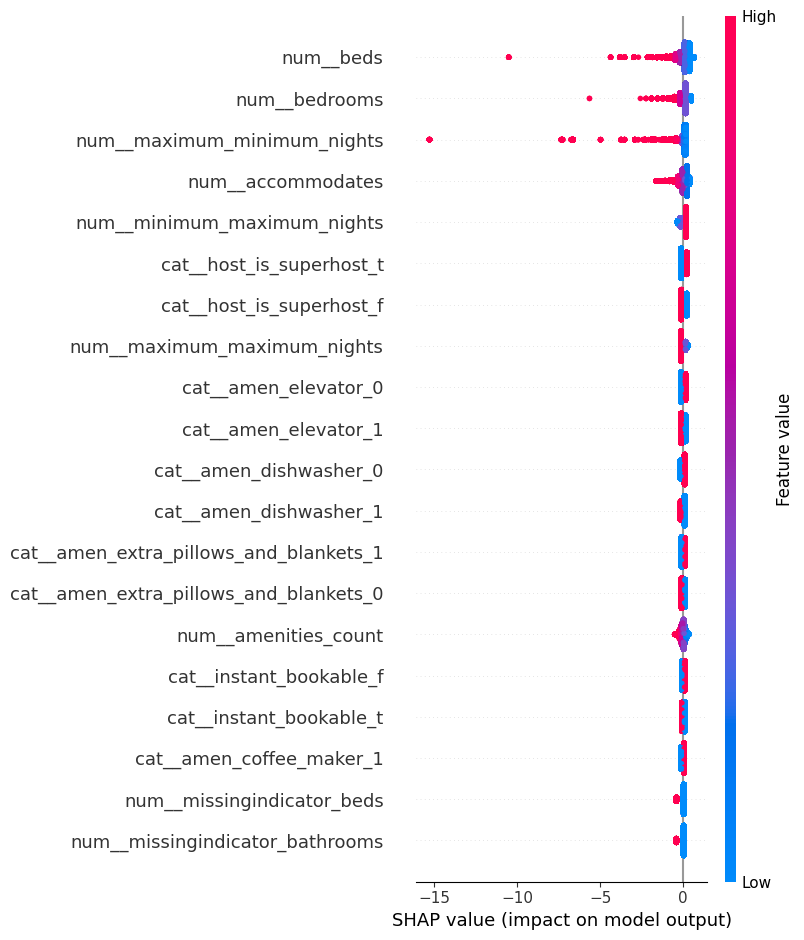

In [6]:
pipe: Pipeline = joblib.load(MODEL_A_PATH)
logreg: LogisticRegression = pipe.named_steps["clf"]

df = load_dataset(DATA)
X, _, _ = prepare_xyg(df)

prep = pipe.named_steps["prep"]
X_trans = prep.transform(X)
feature_names = prep.get_feature_names_out()

X_shap = pd.DataFrame(X_trans, columns=feature_names)
top_logreg_features(logreg, X_shap, n_features=20)


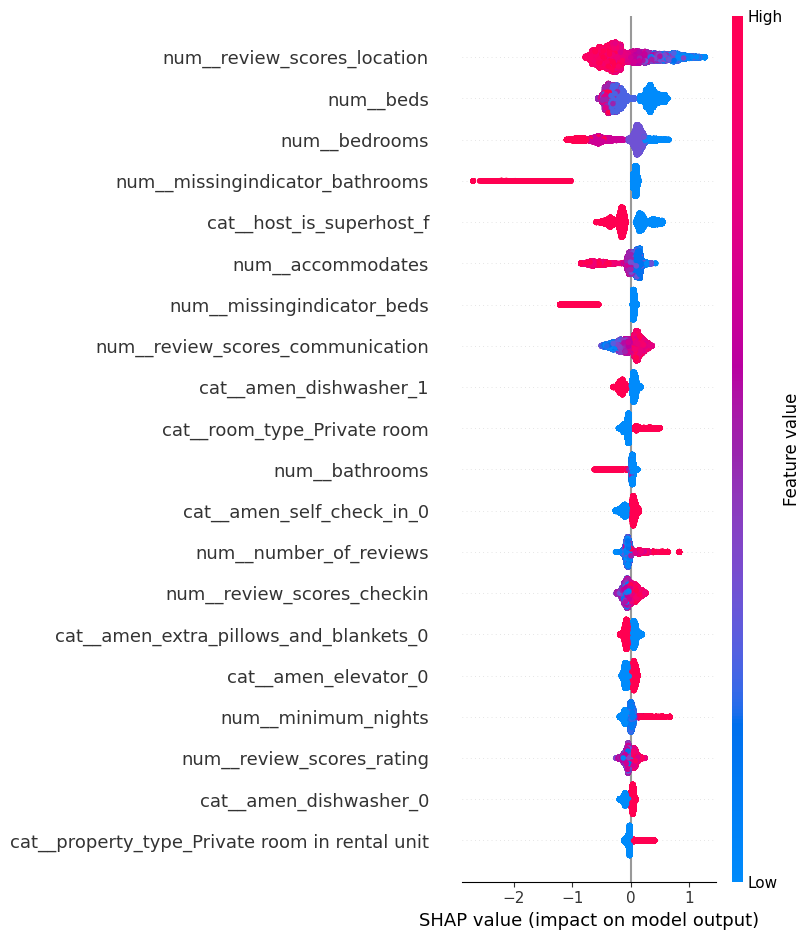

In [5]:
pipe: Pipeline = joblib.load(MODEL_B_PATH)
xgb: XGBClassifier = pipe.named_steps["clf"]

df = load_dataset(DATA)
X, _, _ = prepare_xyg(df)

prep = pipe.named_steps["prep"]
X_trans = prep.transform(X)
feature_names = prep.get_feature_names_out()

X_shap = pd.DataFrame(X_trans, columns=feature_names)
top_xgb_shap_features(xgb, X_shap, n_features=20)


## Interpretacja wyników

Analiza interpretowalności modelu (SHAP) wskazuje, że największy wpływ na
przewidywanie długich rezerwacji mają cechy związane z wielkością obiektu
(liczba łóżek, sypialni oraz pojemność). W danych mniejsze lokale częściej są
klasyfikowane jako odpowiednie pod dłuższy pobyt, co można logicznie
interpretować jako efekt popytu na zakwaterowanie dla osób podróżujących
samodzielnie (np. delegacje służbowe, praca zdalna, studia, staże). Tacy goście
zwykle nie potrzebują dużej przestrzeni, ale bardziej zależy im na
funkcjonalności i wygodzie pobytu „jak w domu”.

Istotnym czynnikiem są również zasady pobytu (zmienne związane z ograniczeniami
liczby nocy). Sugeruje to, że w przypadku dłuższych rezerwacji ważna jest
przewidywalność i elastyczność oferty – zbyt restrykcyjne limity mogą obniżać
prawdopodobieństwo wyboru obiektu na dłuższy okres.

Jednocześnie cechy jakościowe, takie jak status superhosta oraz elementy
związane z ocenami, mają zauważalny wpływ, ale mniejszy niż parametry rozmiaru i
zasad pobytu. Może to oznaczać, że przy dłuższych rezerwacjach kluczowe jest
przede wszystkim dopasowanie obiektu do konkretnego segmentu gości, a dopiero w
drugiej kolejności czynniki reputacyjne.

## Co to oznacza dla rekomendacji dla gospodarzy

Ponieważ celem projektu jest generowanie danych do rekomendacji konsultantów,
wyniki mogą posłużyć do stworzenia praktycznych sugestii, np.:

1. Dostosowanie oferty do “solo long-stay”

   - podkreślanie w opisie: idealne na delegacje / pracę zdalną / studia
   - przygotowanie miejsca pod dłuższy pobyt jednej osoby (komfort spania +
     przestrzeń do życia)

1. Funkcjonalność ważniejsza niż „duży metraż”

   Skoro mniejsze obiekty częściej łapią długie rezerwacje, konsultanci mogą
   sugerować:

   - lepsze wykorzystanie przestrzeni (np. wygodne łóżko, porządek, ergonomia)
   - poprawę elementów, które wpływają na komfort życia codziennego

1. Stabilność i przewidywalne zasady pobytu

   Zmienne związane z limitami nocy są istotne, więc można sugerować:

   - bardziej “long-stay friendly” zasady (tam gdzie to możliwe)
   - klarowne warunki i brak niepotrzebnych ograniczeń

1. Reputacja pomaga, ale nie jest głównym czynnikiem

   Status superhosta ma znaczenie, ale mniejsze niż cechy obiektu – więc:

   - warto pracować nad ocenami, ale priorytetem powinno być dopasowanie
     produktu do segmentu

# Podsumowanie

W modelu skupiono się na danych, które są jednocześnie wiarygodne i przydatne do
tworzenia rekomendacji dla konsultantów. Wykorzystano głównie cechy ofert oraz
udogodnienia, a wykluczono zmienne, które są trudne do poprawnego powiązania w
czasie z rezerwacjami (szczególnie `price`) oraz dane, które nie przekładają się
na działania właścicieli.

Wyniki interpretacji modelu potwierdzają, że na długie rezerwacje najsilniej
wpływają cechy możliwe do adresowania przez gospodarzy: dopasowanie obiektu do
segmentu gości (w szczególności “solo long-stay”) oraz przejrzyste i spójne
zasady pobytu. Dzięki temu wygenerowane rekomendacje mogą być nie tylko trafne,
ale też praktyczne do wdrożenia.